In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
 
 
 
 
def load_and_clean_data(file):
    df = pd.read_csv(file)
   
   
    df = df.dropna(subset=["Life_expectancy"])
 
 
    df = df.drop(columns=["Country", "Region", "Year"], errors='ignore')
 
    for col in df.select_dtypes(include=[np.number]):
        df[col] = df[col].fillna(df[col].median())
 
    return df

In [17]:
def eda(df):
    print("\nCorrelation with Life Expectancy:")
    print(df.corr()['Life_expectancy'].sort_values(ascending=False))
 
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title("Correlation Matrix")
    plt.show()

In [18]:
def feature_engineeringV2(X):

    '''
    This function inputs a dataframe df and returns a feature engineered version of the dataframe.
    It performs the following steps:
    
Drops the columns 'Country', 'Region', 'Life_expectancy', 'Economy_status_Developed', 'Economy_status_Developing', and 'Measles'.
Creates a dataframe X and series y for feature engineering.
Removes highly correlated features with a correlation greater than 0.9.
Scales the features using StandardScaler.
Calculates the Variance Inflation Factor (VIF) for each feature and drops features with a VIF greater than 10.
Returns the feature engineered version of X and y.'''

    # Drops the columns that are not needed for feature engineering and transform columns.
    X = X.drop(columns=['Country', 'Region', 'Economy_status_Developed', 'Economy_status_Developing', 'Measles'])
    transform_cols = ['GDP_per_capita', 'Incidents_HIV']  # Columns to be transformed
    X[transform_cols] = np.log1p(X[transform_cols])  
    corr_matrix = X.corr().abs() # Creates a correlation matrix for all the values in the X dataframe, making sure its absolute values (this prevents a division by zero error).
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool)) # Takes the upper triangle of the correlation matrix, k = 1, is the upper diagonal, and changes the type to boolean.
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] # Takes all the columns with correlation greater than 0.9 in one list.
    X = X.drop(columns=to_drop) # Drops all of the columns with the correlations > 0.9 - this is the feature selection step.

    # Remove features with low variance or high VIF
    X_scaled = StandardScaler().fit_transform(X) # Uses the StandardScaler() from sklearn and uses fit_transform on X to scale it using the mean and standard deviation.
    X_df = pd.DataFrame(X_scaled, columns = X.columns) # Converts the above X_scaled back into a dataframe - as it is an np array.

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df.columns # Adds a column called feature and fills it with the columns from X.
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])] # Iterates through and calculates the VIF for each feature.
    X = X_df.drop(columns = vif_data[vif_data["VIF"] > 10]["feature"]) # Drops the columns with a VIF value > 10, as this suggests high multicollinearity.

    # Returns the feature engineered version of X and y.
    return X, y


In [19]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
 
    model = sm.OLS(y_train, X_train_const).fit()
 
    print(model.summary())
 
    y_pred = model.predict(X_test_const)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    condition_number = np.linalg.cond(X_train_const)
 
    print(f"\nTest RMSE: {rmse}")
    print(f"Condition Number: {condition_number}")
 
    return model


Correlation with Life Expectancy:
Life_expectancy                1.000000
Schooling                      0.732484
Polio                          0.641217
Diphtheria                     0.627541
BMI                            0.598423
GDP_per_capita                 0.583090
Economy_status_Developed       0.523791
Measles                        0.490019
Hepatitis_B                    0.417804
Alcohol_consumption            0.399159
Population_mln                 0.026298
Thinness_five_nine_years      -0.458166
Thinness_ten_nineteen_years   -0.467824
Economy_status_Developing     -0.523791
Incidents_HIV                 -0.553027
Infant_deaths                 -0.920032
Under_five_deaths             -0.920419
Adult_mortality               -0.945360
Name: Life_expectancy, dtype: float64


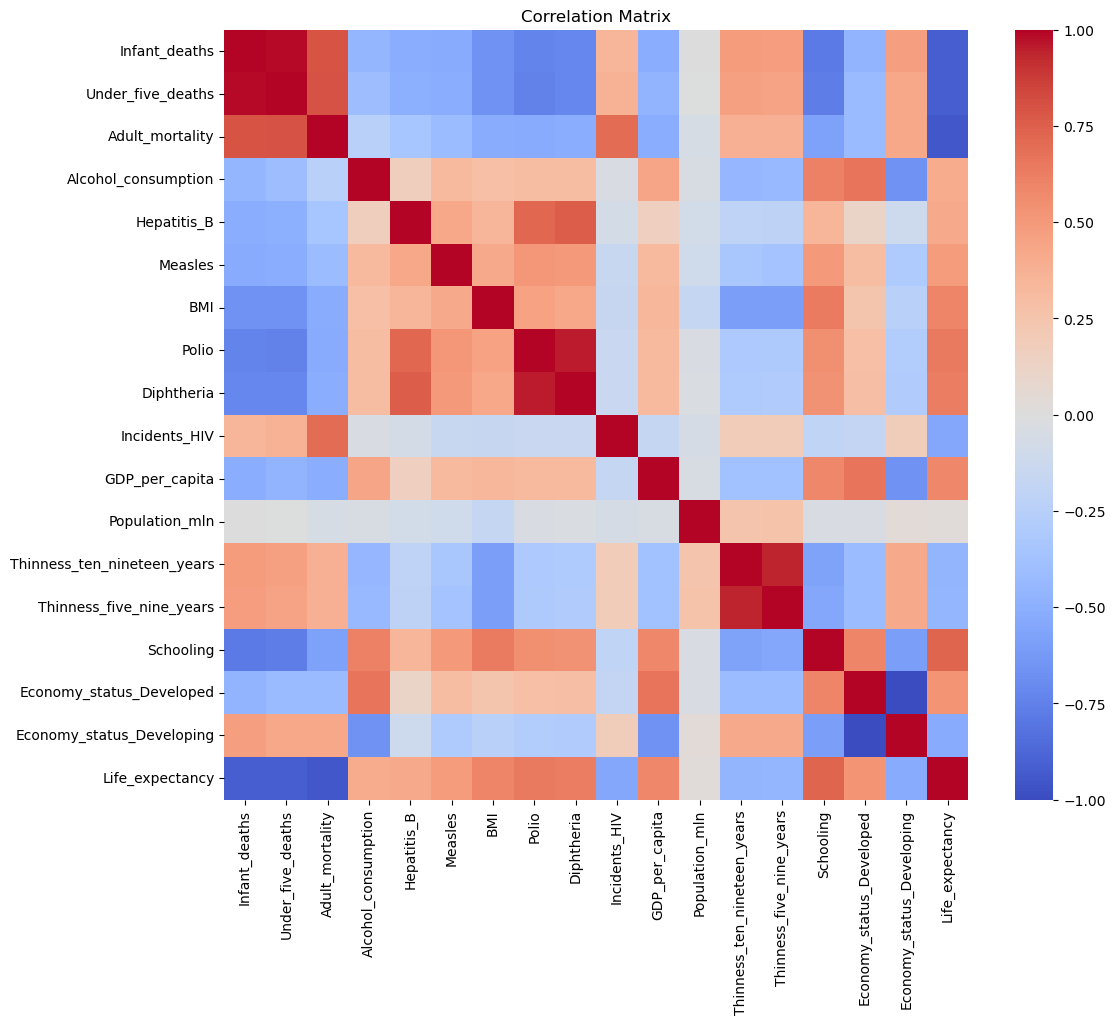

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     7858.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:57:07   Log-Likelihood:                -4020.2
No. Observations:                2291   AIC:                             8068.
Df Residuals:                    2277   BIC:                             8149.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [20]:
def full_pipeline(file):
    df = load_and_clean_data(file)
    eda(df)
    X, y = feature_engineering(df)
    model = train_model(X, y)
    return model

model = full_pipeline('Life Expectancy Data.csv')

In [21]:
model.save("non_sensitive_model.plk")

In [23]:
model.save("sensitive_model.plk")
'''
user_info_specs_Sensitive = [
    {'prompt': "Alcohol consumption per person per year in litres?", 'type': float},
    {'prompt': "average BMI", 'type': float},
    {'prompt': "GDP per capita", 'type': int},
    {'prompt': "Population in million", 'type': float},
    {'prompt': "what percentage of the population between1 1-19 years are thin(%)", 'type': float},
    {'prompt': "Number of years of Schooling(years)",'type':float}
    '''

'\nuser_info_specs_Sensitive = [\n    {\'prompt\': "Alcohol consumption per person per year in litres?", \'type\': float},\n    {\'prompt\': "average BMI", \'type\': float},\n    {\'prompt\': "GDP per capita", \'type\': int},\n    {\'prompt\': "Population in million", \'type\': float},\n    {\'prompt\': "what percentage of the population between1 1-19 years are thin(%)", \'type\': float},\n    {\'prompt\': "Number of years of Schooling(years)",\'type\':float}\n    '